In [15]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch

from importlib import reload
from copy import deepcopy
from typing import List
from collections import deque, namedtuple

import random

import utils.plots_cliffwalking as plots
from env.cliff_walking import WindyCliffWalking


# Resolvendo o ambiente Cliff Walking com Deep Q-Learning

O [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) será utilizado novamente para entendermos o funcionamento do Deep Q-Learning, o algoritmo mais simples de Deep Reinforcement Learning. Recapitulando o objetivo do Cliff Walking, o agente deve ser capaz de atravessar um tabuleiro do início ao fim tomando cuidado para não cair em um penhasco. Se o agente cair no penhasco, ele retorna para o início do tabuleiro e leva uma penalidade de recompensa.

<img src="media/cliff_walking.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Cima
* 1: Direita
* 2: Baixo
* 3: Esquerda

### Espaço de estados

O estado representa a posição do jogador no tabuleiro. Logo, o espaço de estados também é discreto e contém os inteiros do intervalo {0, 47}. O valor numérico da posição do agente no tabuleiro pode ser obtido como linha_atual * nlinhas + coluna, sendo que as linhas e colunas começam em 0.

### Recompensas

A cada movimento do agente uma penalidade de -1 é aplicada, a menos que o jogador caia do penhasco, o que resulta em uma penalidade -100.


### Conversão de inteiro para (x,y)

A rede neural fica mais simples se receber como entrada um par (x,y) em vez de um inteiro. Se fossemos alimentá-la com um inteiro, teríamos que converter esse inteiro para um one-hot. Como são 48 estados, precisaríamos de um vetor de 48 elementos, sendo 47 elementos zerados! Ao passarmos um par (x,y), o vetor fica reduzido para apenas dois elementos. A função abaixo codifica o estado para a posição do agente.

In [25]:
def encode_state(state) -> torch.Tensor:
    state = torch.tensor(state, dtype=torch.float32)
    x = (state % 12) / 11
    y = (state // 12) / 3

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    return torch.cat([x, y], dim=-1)

## Criando o modelo

No Deep Q-Learning, os Q-valores de cada ação associados a um estado são calculados através de uma rede neural. Ou seja, a rede neural recebe como entrada um vetor de estados e deve retornar o vetor de Q-valores onde cada elemento representa o Q-valor da ação i. Um Q-valor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio".

Por se tratar de um problema relativamente simples, o modelo para solucionar o CliffWalking pode ser uma rede MLP simples com uma única camada oculta. Além disso, note que a predição dos Q-valores é uma tarefa de regressão, portanto não há necessidade de softmax no final da rede. 

In [26]:
class Qnet(torch.nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64]):
        super().__init__()

        layers = []
        input_size = 2 # entrada: posicao (x, y)
        for n_neurons in layer_sizes:
            layers.append(torch.nn.Linear(input_size, n_neurons))
            layers.append(torch.nn.ReLU())
            input_size = n_neurons
        layers.append(torch.nn.Linear(input_size, 4))
        self.model = torch.nn.Sequential(*layers)

    def initialize(self):
        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.01)

    def forward(self, x):
        x = encode_state(x)
        x = self.model(x)
        return x

## Replay buffer

In [27]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=1024):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        """Save a transition in the buffer"""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo Q-Valor é o maior. No entanto, para que o Q-Learning convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que o agente visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [28]:
def get_action(model, state, epsilon, random=True, n_actions=4):
    state = torch.tensor(state, dtype=torch.float32)
    if torch.rand(1) < epsilon and random:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(state)
    return torch.argmax(qvals).item()

## Treinamento da rede neural 

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para calcular uma loss e atualizar seus pesos de forma a minimizá-la. A loss que será utilizada é o erro quadrático médio entre o Q-valor escolhido e o maior Q-valor do próximo estado calculado utilizando a rede com os pesos anteriores à ultima atualização:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note que, portanto, serão necessárias duas redes neurais com a mesma arquitetura, mas uma terá os pesos deefasados em uma iteração com relação à outra.

In [29]:
def update_q_net(model: torch.nn.Module, 
                 model_target: torch.nn.Module,
                 optimizer: torch.optim.Optimizer, 
                 batch_of_transitions: List[Transition],
                 gamma):
    
    # convertendo uma lista de Transitions para uma Transition de listas
    batch = Transition(*zip(*batch_of_transitions))
    
    # transformando o batch de estados em um tensor
    states = torch.tensor(batch.state)
    actions = torch.tensor(batch.action)
    rewards = torch.tensor(batch.reward)
    next_states = torch.tensor(batch.next_state)
    terminated = torch.tensor(batch.done)
    
    optimizer.zero_grad()
    qvals = model(states)[actions]
    predictions = torch.gather(qvals, 1, actions.unsqueeze(1)) # seleciona o qval da acao tomada

    # se o estado é terminal, o valor é a recompensa
    with torch.no_grad():
        targets = torch.where(terminated, # if terminated
                              rewards, # then rewards 
                              rewards + gamma * torch.max(model_target(next_states))) # else rewards + gamma * max_a Q(s', a)
    
    loss = torch.nn.functional.mse_loss(predictions, targets)
    loss.backward()

    # atualizando os pesos da rede defasada
    model_target.load_state_dict(model.state_dict())

    # atualizando os pesos da rede
    optimizer.step()

    return model, model_target

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [30]:
def train(env: gym.Env, 
          model: torch.nn.Module,
          replay_buffer_size=1024, # tamanho do replay buffer
          n_episodes=5000, # numero maximo de episodios
          batch_size=16, # tamanho do batch
          epsilon=0.9, # probabilidade inicial de escolher uma ação aleatória
          epsilon_decay=0.999, # fator de decaimento da probabilidade de escolher uma ação aleatória
          learning_rate=0.0001, # taxa de aprendizado
          gamma=0.99, # fator de desconto
          verbose=False):
    
    model_target = deepcopy(model)

    model.initialize()
    model_target.initialize()

    replay_buffer = ReplayBuffer(replay_buffer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_rewards = []
    avg_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 500 steps max
            # observe
            action = get_action(model, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            replay_buffer.push(state, action, next_state, reward, terminated)
            state = next_state
            total_reward += reward

            # update
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                model, model_target = update_q_net(model, model_target, optimizer, batch, gamma)
            
            done = terminated or truncated
            step += 1
        
        total_rewards.append(total_reward)
        avg_reward = sum(total_rewards[-50:]) / len(total_rewards[-50:])
        if episode % 50:
            avg_rewards.append(avg_reward)
        if episode % 100 == 0 and verbose:
            clear_output(wait=True)
            debug_model.load_state_dict(model.state_dict())
            print(f"Episode {episode} - Average total reward: {avg_reward} - epsilon: {epsilon}")
            plt.plot(avg_rewards)
            plt.show()

    return model

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

Episode 480 - Average total reward: -2445.36 - epsilon: 0.5562145509778935


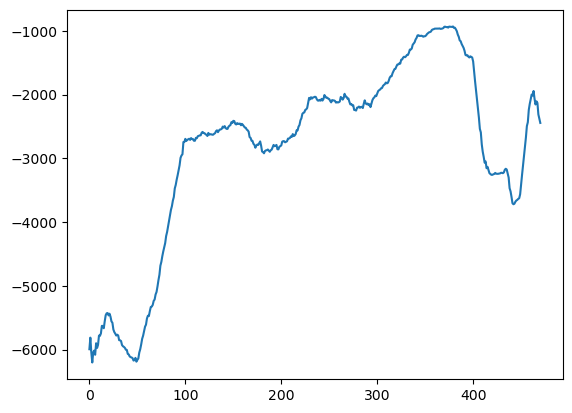

In [31]:
cliff_walking = gym.make('CliffWalking-v0')
q_net = Qnet(layer_sizes=[64, 64])
debug_model = deepcopy(q_net)
trained_q_net = train(cliff_walking, q_net, batch_size=64, epsilon_decay=0.99, learning_rate=1e-5, verbose=True)

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return torch.mean(total_reward)

#test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_net)

## Análise de resultados

### Visualizando a política

A célula abaixo permitirá observar a ação mais provável de ser tomada em cada uma das posições do tabuleiro.

AttributeError: 'float' object has no attribute 'reshape'

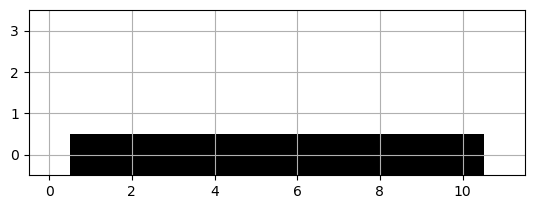

In [24]:
reload(plots)
plots.plot_arrows_from_qnet(debug_model)

In [ ]:
for state in range(48):
    print(f'state {state}: {debug_model(state).detach().numpy()}')

state 0: [-99.32302 -99.32125 -99.32189 -99.39064]
state 1: [-99.37512  -99.38653  -99.397316 -99.32632 ]
state 2: [-99.42722 -99.45182 -99.47275 -99.262  ]
state 3: [-99.479324 -99.517105 -99.54818  -99.19767 ]
state 4: [-99.531425 -99.58239  -99.62361  -99.13336 ]
state 5: [-99.58353  -99.64768  -99.69904  -99.069046]
state 6: [-99.63563  -99.712975 -99.77447  -99.00472 ]
state 7: [-99.68773 -99.77827 -99.8499  -98.9404 ]
state 8: [-99.73983  -99.843544 -99.92533  -98.87608 ]
state 9: [ -99.79193   -99.90884  -100.00076   -98.811775]
state 10: [ -99.844025  -99.97412  -100.07619   -98.747444]
state 11: [ -99.896126 -100.03941  -100.15163   -98.68313 ]
state 12: [ -99.34171  -101.59196   -99.90222   -99.441574]
state 13: [ -99.39381 -101.65725  -99.97765  -99.37725]
state 14: [ -99.4459   -101.722534 -100.05308   -99.312935]
state 15: [ -99.498   -101.78782 -100.12851  -99.24861]
state 16: [ -99.55011  -101.85311  -100.20393   -99.184296]
state 17: [ -99.60221  -101.918396 -100.27936 

### Visualizando a influência da taxa de aprendizado

A célula abaixo criará um gráfico com a recompensa total média de um conjunto de agentes treinados com uma diferente taxa de aprendizado. Como você explicaria os resultados?

In [ ]:
# retorno médio esperado em função de alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

NameError: name 'np' is not defined

## Exercício - ambientes não-determinísticos

Agora que já vimos que o agente aprendeu um caminho para o objetivo que minimiza a distância caminhada e não cai no penhasco, está na hora de deixar as coisas um pouco mais difíceis. Utilizaremos agora uma versão modificada do Cliff Walking que adiciona vento aleatório na direção do penhasco. Ou seja, existe uma probabilidade do agente ser deslocado uma casa para baixo de maneira involuntária.

Essa alteração será interessante para observarmos a infuência da taxa de aprendizado no treinamento de um modelo robusto a ambientes não-determinísticos.

In [ ]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(cliff_walking, windy_q_table, alpha=0.75, verbose=True)

### Resultados

In [ ]:
windy_cliff_walking.render_mode = 'human'
test(windy_cliff_walking, trained_windy_q_table)

In [ ]:
plots.plot_arrows(trained_q_table)